In [27]:
# import libs
from itertools import islice

from matplotlib import pyplot as plt
import matplotlib.dates as mdates

import torch
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset

from gluonts.dataset.pandas import PandasDataset
import pandas as pd
import numpy as np
from lag_llama.gluon.estimator import LagLlamaEstimator

### vis for each feature

In [54]:
# take train_FD001 as example
df = pd.read_csv('/Users/junbo/studium/ma/CMAPSS Data/train_FD001.txt', index_col=0, sep=" ", header=None)

In [55]:
column_indices = np.arange(df.shape[1]-1).tolist()

index_columns_names =  ["cycle"]
op_settings_columns = ["op_setting_"+str(i) for i in range(1,4)]
sensor_columns =["sensor_"+str(i) for i in range(1,22)]
new_names = index_columns_names + op_settings_columns + sensor_columns

old_names = df.columns[column_indices]
df.rename(columns=dict(zip(old_names, new_names)), inplace=True)
df.index.names = ['engine']
df.drop([26, 27], axis=1, inplace=True)
df_sensor = df.drop(['op_setting_1', 'op_setting_2', 'op_setting_3'], axis=1) 
# df_sensor only contains sensor data, df contains all the op_setting data + sensor data

              cycle  sensor_1  sensor_2  sensor_3  sensor_4  sensor_5  \
cycle      1.000000       NaN  0.549898  0.543947  0.624577       NaN   
sensor_1        NaN       NaN       NaN       NaN       NaN       NaN   
sensor_2   0.549898       NaN  1.000000  0.602610  0.714949       NaN   
sensor_3   0.543947       NaN  0.602610  1.000000  0.678413       NaN   
sensor_4   0.624577       NaN  0.714949  0.678413  1.000000       NaN   
sensor_5        NaN       NaN       NaN       NaN       NaN       NaN   
sensor_6   0.105980       NaN  0.132242  0.116039  0.150480       NaN   
sensor_7  -0.595914       NaN -0.702136 -0.664595 -0.793130       NaN   
sensor_8   0.475977       NaN  0.662325  0.602481  0.746852       NaN   
sensor_9   0.443999       NaN  0.273764  0.322964  0.297429       NaN   
sensor_10       NaN       NaN       NaN       NaN       NaN       NaN   
sensor_11  0.634385       NaN  0.740020  0.695900  0.830136       NaN   
sensor_12 -0.611354       NaN -0.724578 -0.680307 -

/Users/junbo/miniconda3/envs/lag_llama/lib/python3.12/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


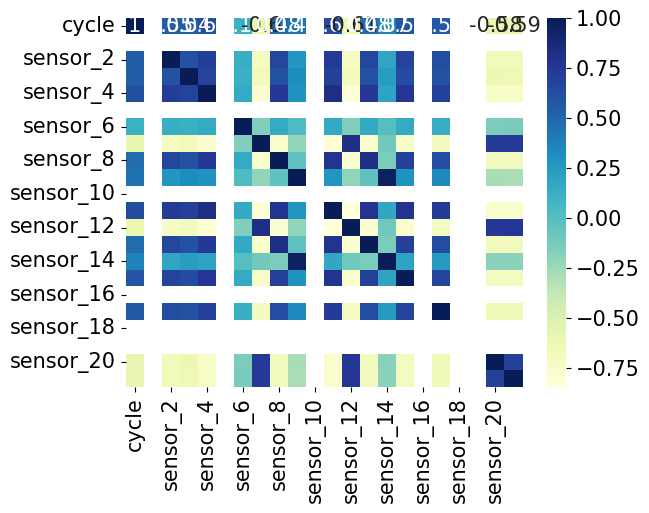

In [200]:
# correlation matrix

import matplotlib.pyplot as mp 
import pandas as pd 
import seaborn as sb 

# prints data that will be plotted 
# columns shown here are selected by corr() since 
# they are ideal for the plot 
print(df_sensor.corr()) 

# plotting correlation heatmap 
dataplot = sb.heatmap(df_sensor.corr(), cmap="YlGnBu", annot=True) 
# displaying heatmap 
mp.show() 


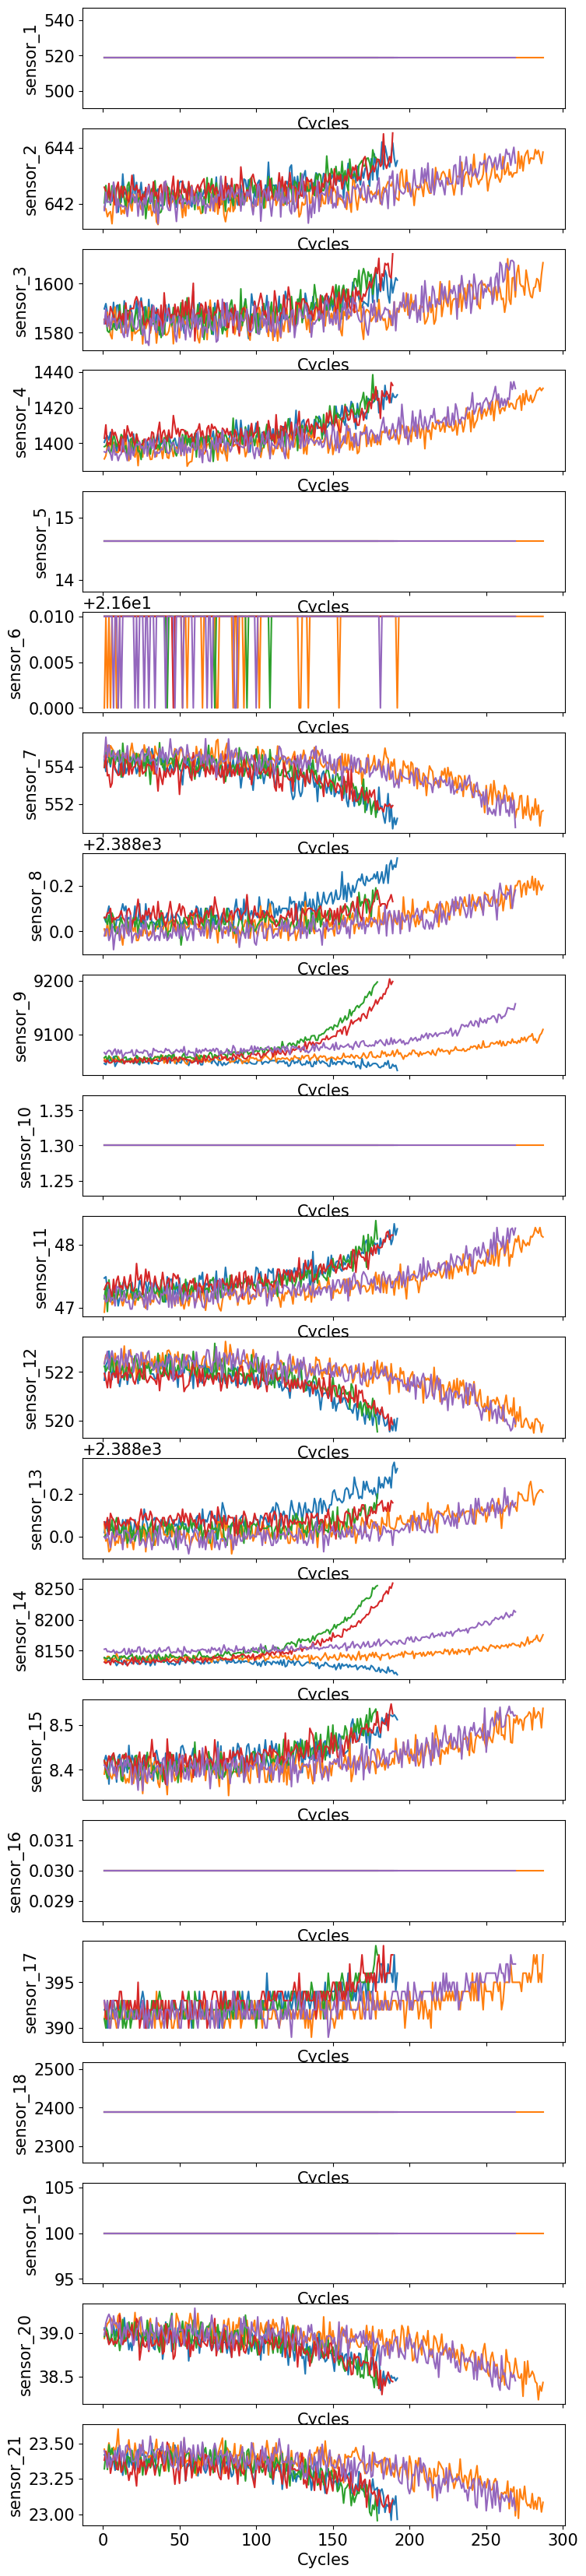

In [206]:
# plot the first 5 trajecotry (#engine 1, 2, 3, 4, 5)
df_sensor_top5 = df_sensor[df_sensor.index<=5]
# df_sensor_top5 = df_sensor[(df_sensor.index<=5) & (df_sensor.cycle <= 128)]
timestamp_col = df_sensor_top5['cycle']
sensor_cols = df_sensor_top5.columns[1:]
num_features = len(df_sensor_top5.columns) - 1
fig, axs = plt.subplots(nrows=num_features, ncols=1, figsize=(8, 2*num_features), sharex=True)

for i, col in enumerate(sensor_cols):
    for trj in df_sensor_top5.index.unique():
        df_subset = df_sensor_top5.loc[trj]
        axs[i].plot(df_sensor_top5[df_sensor_top5.index==trj]['cycle'], 
                df_subset[col], label=trj)
        axs[i].set_xlabel('Cycles')
        axs[i].set_ylabel(col)
plt.show()

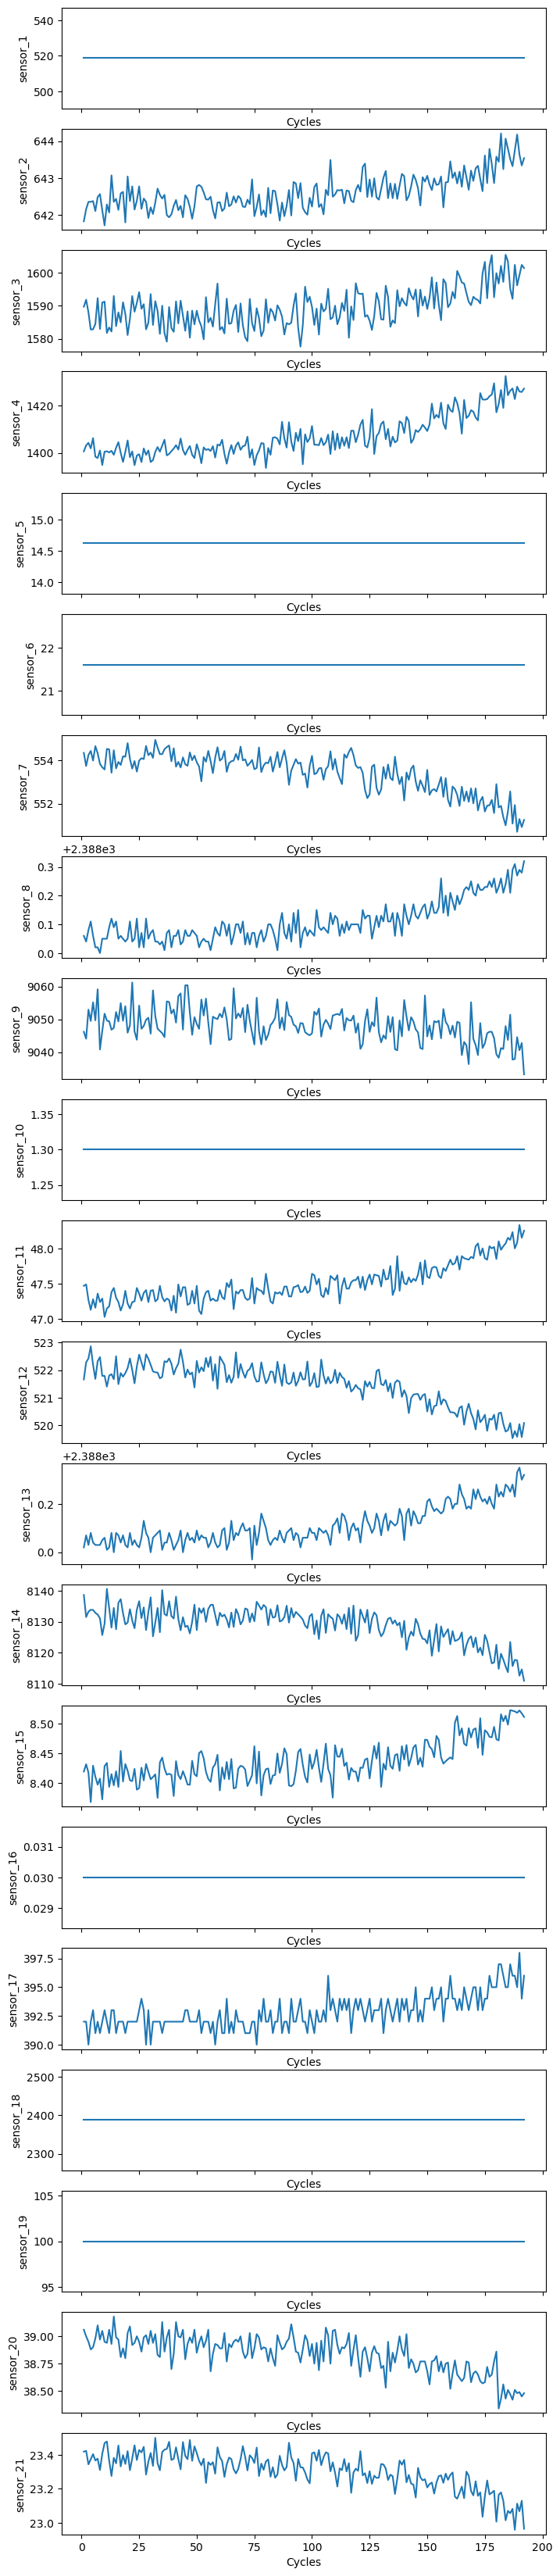

In [103]:
df_sensor_top1 = df_sensor[df_sensor.index==1]

timestamp_col = df_sensor_top1['cycle']
sensor_cols = df_sensor_top1.columns[1:]
num_features = len(df_sensor_top1.columns) - 1
fig, axs = plt.subplots(nrows=num_features, ncols=1, figsize=(8, 2*num_features), sharex=True)

for i, col in enumerate(sensor_cols):
    for trj in df_sensor_top1.index.unique():
        df_subset = df_sensor_top1.loc[trj]
        axs[i].plot(df_sensor_top1[df_sensor_top1.index==trj]['cycle'], 
                df_subset[col], label=trj)
        axs[i].set_xlabel('Cycles')
        axs[i].set_ylabel(col)
plt.show()

### zero-shot forecasting on engine 1

In [104]:
import torch
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset

from gluonts.dataset.pandas import PandasDataset
import pandas as pd

from lag_llama.gluon.estimator import LagLlamaEstimator

In [152]:
ckpt = torch.load("lag-llama.ckpt", map_location=device)
for key, value in ckpt["hyper_parameters"]["model_kwargs"].items():
    print(key, ':', value)


input_size : 1
context_length : 32
max_context_length : 2048
lags_seq : [0, 7, 8, 10, 11, 12, 13, 14, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 34, 35, 36, 46, 47, 48, 50, 51, 52, 55, 57, 58, 59, 60, 61, 70, 71, 72, 83, 94, 95, 96, 102, 103, 104, 117, 118, 119, 120, 121, 142, 143, 144, 154, 155, 156, 166, 167, 168, 177, 178, 179, 180, 181, 334, 335, 336, 362, 363, 364, 502, 503, 504, 670, 671, 672, 718, 719, 720, 726, 727, 728, 1090, 1091, 1092]
n_layer : 8
n_embd_per_head : 16
n_head : 9
scaling : robust
distr_output : gluonts.torch.distributions.studentT.StudentTOutput()
num_parallel_samples : 100
rope_scaling : None
time_feat : True
dropout : 0.0


In [105]:
def get_lag_llama_predictions(dataset, 
                              prediction_length, 
                              device, 
                              context_length=32, 
                              use_rope_scaling=False, 
                              num_samples=100):
    
    ckpt = torch.load("lag-llama.ckpt", map_location=device) # Uses GPU since in this Colab we use a GPU.
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

    rope_scaling_arguments = {
        "type": "linear",
        "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
    }

    estimator = LagLlamaEstimator(
        ckpt_path="lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length, # Lag-Llama was trained with a context length of 32, but can work with any context length

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],
        rope_scaling=rope_scaling_arguments if use_rope_scaling else None,

        batch_size=1,
        num_parallel_samples=100,
        device=device,
    )

    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    forecasts = list(forecast_it)
    tss = list(ts_it)

    return forecasts, tss

In [127]:
# reconstruct dataframe for conformity
df1 = df_sensor[df_sensor.index==1]
sensor_names = df1.columns[1:]

# Melt the DataFrame
melted_df1 = pd.melt(df1, id_vars=['cycle'], value_vars=sensor_names, var_name='item_id' ,value_name='target')
melted_df1.reset_index(drop=True).set_index('cycle')
# melted_df1 shape: (192x21), 2

,item_id,target
cycle,,
1,sensor_1,518.6700
2,sensor_1,518.6700
3,sensor_1,518.6700
4,sensor_1,518.6700
5,sensor_1,518.6700
...,...,...
188,sensor_21,22.9588
189,sensor_21,23.1127
190,sensor_21,23.0675


In [128]:
# Set numerical columns as float32
df = melted_df1

for col in df.columns:
    # Check if column is not of string type
    if df[col].dtype != 'object' and pd.api.types.is_string_dtype(df[col]) == False:
        df[col] = df[col].astype('float32')

# Create PandasDataset
dataset = PandasDataset.from_long_dataframe(df, target="target", item_id='item_id')

backtest_dataset = dataset
prediction_length = 24  # Define your prediction length. We use 24 here since the data is of hourly frequency
num_samples = 100 # number of samples sampled from the probability distribution for each timestep
device = torch.device("cpu")

In [129]:
forecasts, tss = get_lag_llama_predictions(backtest_dataset, prediction_length, device, num_samples)

In [144]:
print(len(forecasts), forecasts[0].samples.shape)
forecasts[0].samples

21 (100, 24)


array([[518.67, 518.67, 518.67, ..., 518.67, 518.67, 518.67],
       [518.67, 518.67, 518.67, ..., 518.67, 518.67, 518.67],
       [518.67, 518.67, 518.67, ..., 518.67, 518.67, 518.67],
       ...,
       [518.67, 518.67, 518.67, ..., 518.67, 518.67, 518.67],
       [518.67, 518.67, 518.67, ..., 518.67, 518.67, 518.67],
       [518.67, 518.67, 518.67, ..., 518.67, 518.67, 518.67]],
      dtype=float32)

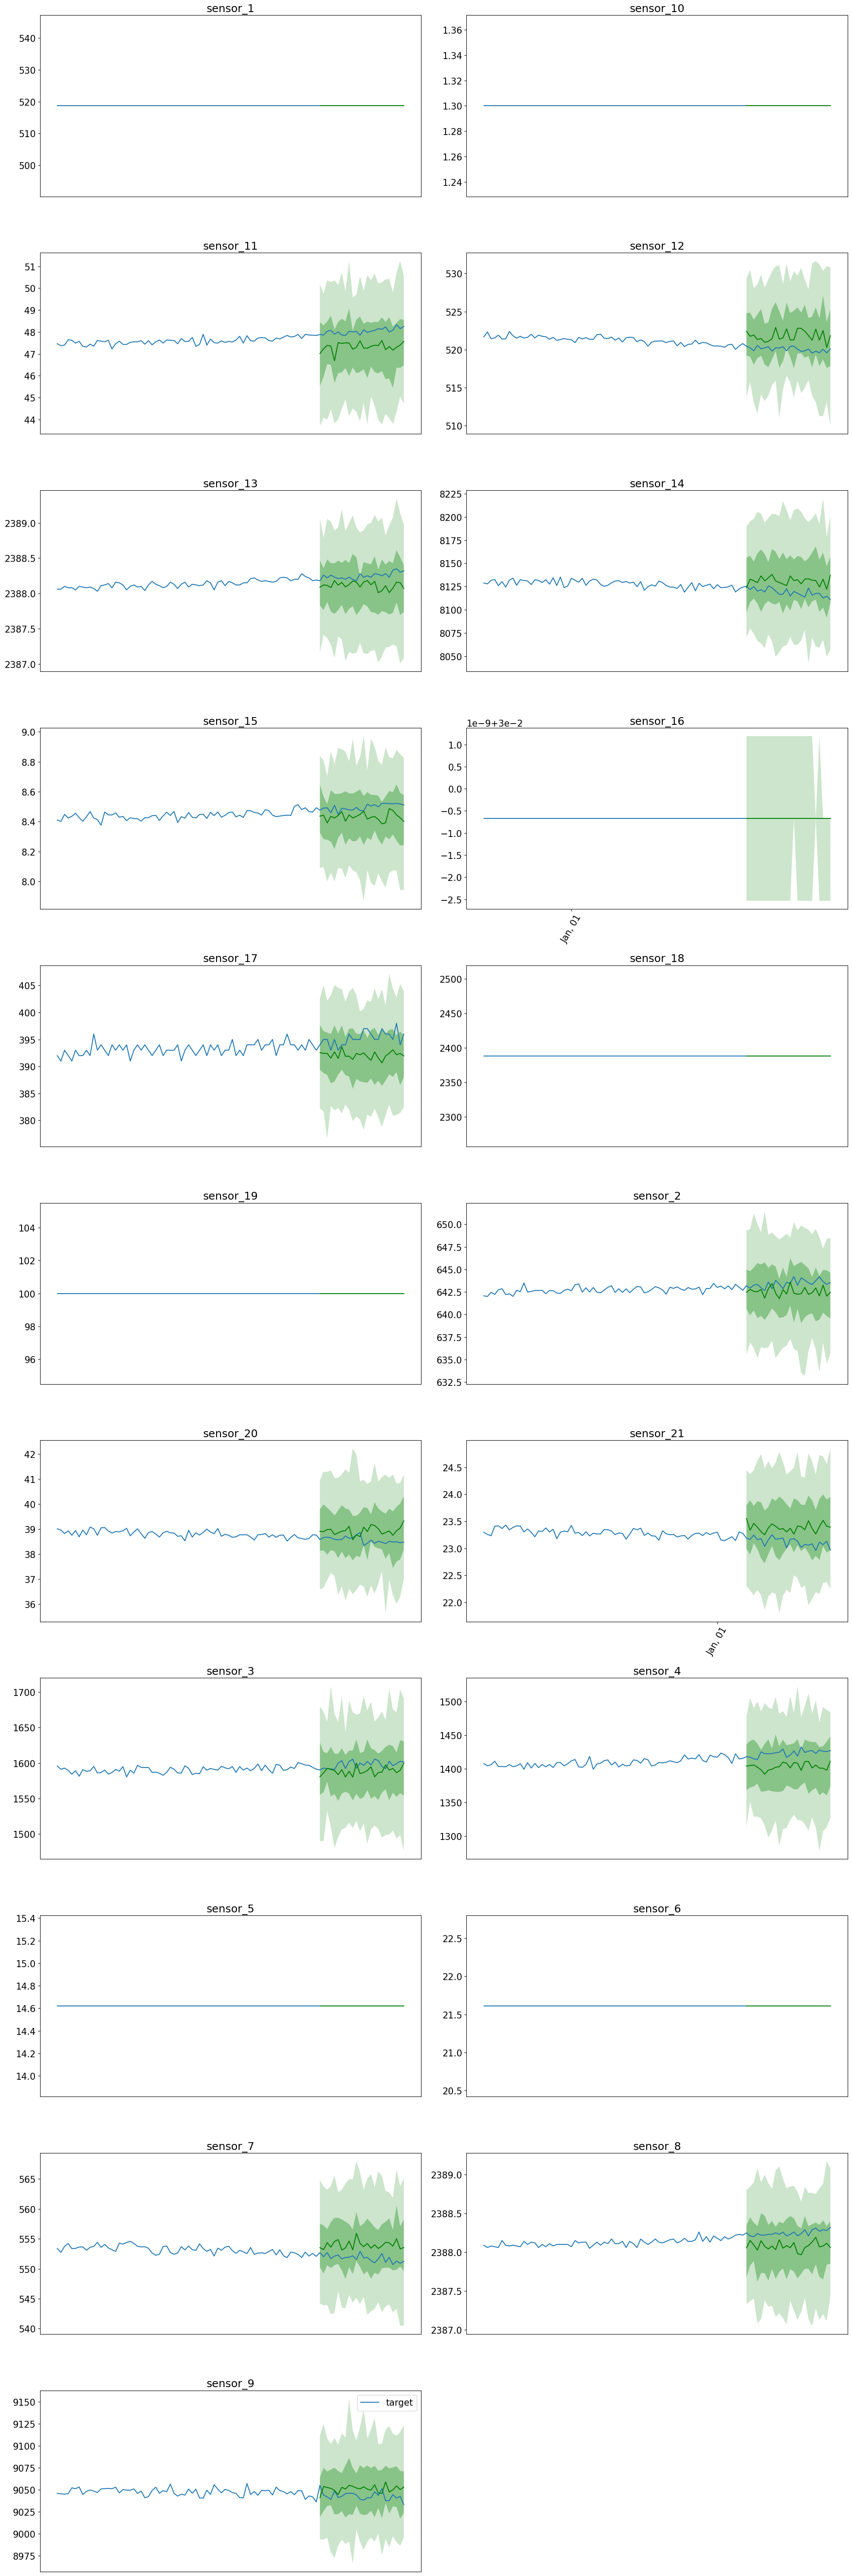

In [142]:
plt.figure(figsize=(20, 60))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

# Iterate through the first 9 series, and plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 21):
    ax = plt.subplot(11, 2, idx+1)

    plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="target", ) # only shows the last 4 prediction lengths
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

### tuning context length for zero-shot, enabling RoPE
model params by default:
- `context_length=32`
- `use_rope_scaling=False`
- `num_samples=100`

### questions on model performance
- c-mapss sensor data don't have clear cyclic patterns (daily, monthly, yearly), is it a problem?
- does RoPE always imporve performance?
- context length, the bigger the better?

In [176]:
# To filter warnings for readability
import warnings
warnings.simplefilter("ignore", UserWarning)

# For this dataset
from gluonts.dataset.common import ListDataset

In [183]:
# drop columns where sensor data don't vary much -> reduce number of divide warnings
df_sensor_top1 = df_sensor_top1.drop(['sensor_1', 'sensor_10', 'sensor_18', 'sensor_19', 'sensor_5', 
                                      'sensor_6'], axis=1)

In [196]:
df_sensor_top1

,sensor_2,sensor_3,sensor_4,sensor_7,sensor_8,sensor_9,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_20,sensor_21
cycle,,,,,,,,,,,,,,,
1970-01-01 01:00:00,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,39.06,23.4190
1970-01-01 02:00:00,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,39.00,23.4236
1970-01-01 03:00:00,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,38.95,23.3442
1970-01-01 04:00:00,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,38.88,23.3739
1970-01-01 05:00:00,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970-01-08 20:00:00,643.75,1602.38,1422.78,551.94,2388.31,9037.91,48.00,519.79,2388.23,8117.69,8.5207,0.03,396,38.51,22.9588
1970-01-08 21:00:00,644.18,1596.17,1428.01,550.70,2388.27,9044.55,48.08,519.58,2388.33,8117.51,8.5183,0.03,395,38.48,23.1127
1970-01-08 22:00:00,643.64,1599.22,1425.95,551.29,2388.29,9040.58,48.33,520.04,2388.35,8112.58,8.5223,0.03,398,38.49,23.0675


In [185]:
prediction_length = 24  # prediction length should be fixed for easy compare
num_samples = 100 # number of samples sampled from the probability distribution for each timestep
device = torch.device("cpu")

# df_sensor_top1 = df_sensor_top1.reset_index(drop=True).set_index('cycle')
# df_sensor_top1.index = pd.to_datetime(df_sensor_top1.index, origin='1970-01-01', unit='h')

# train_data = [{"start": df_sensor_top1.index[0], "target": df_sensor_top1[i].values[:-prediction_length]} for i in df_sensor_top1.columns]
test_data = [{"start": df_sensor_top1.index[0], "target": df_sensor_top1[i].values} for i in df_sensor_top1.columns]

# train_ds = ListDataset(
#     data_iter=train_data,
#     freq='1H'
# )

test_ds = ListDataset(
    data_iter=test_data,
    freq='1H'
)

In [186]:
def getCRPS(context_length, use_rope_scaling):
    forecasts_ctx_len_32, tss_ctx_len_32 = get_lag_llama_predictions(test_ds, prediction_length, device, 
                                                                    context_length, use_rope_scaling, num_samples=100)
    forecasts_ctx_len_32 = list(forecasts_ctx_len_32)
    tss_ctx_len_32 = list(tss_ctx_len_32)

    evaluator = Evaluator()
    agg_metrics_ctx_len_32, ts_metrics_ctx_len_32 = evaluator(iter(tss_ctx_len_32), iter(forecasts_ctx_len_32))
    print("CRPS:", agg_metrics_ctx_len_32['mean_wQuantileLoss'])

In [187]:
# case 1 (repeat default)
context_length = 32
use_rope_scaling=False
getCRPS(context_length, use_rope_scaling)
# CRPS: 0.0022709638517904762

Running evaluation: 15it [00:00, 182.74it/s]


CRPS: 0.0022709638517904762


/Users/junbo/miniconda3/envs/lag_llama/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/Users/junbo/miniconda3/envs/lag_llama/lib/python3.12/site-packages/gluonts/evaluation/metrics.py:105: RuntimeWarning: invalid value encountered in scalar divide
  return np.mean(np.abs(target - forecast)) / seasonal_error
/Users/junbo/miniconda3/envs/lag_llama/lib/python3.12/site-packages/gluonts/evaluation/metrics.py:154: RuntimeWarning: divide by zero encountered in scalar divide
  return numerator / seasonal_error


In [188]:
# case 2
context_length = 32
use_rope_scaling=True
getCRPS(context_length, use_rope_scaling)
# CRPS: 0.0022319215582242116

Running evaluation: 15it [00:00, 161.40it/s]


CRPS: 0.0022319215582242116


/Users/junbo/miniconda3/envs/lag_llama/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/Users/junbo/miniconda3/envs/lag_llama/lib/python3.12/site-packages/gluonts/evaluation/metrics.py:105: RuntimeWarning: invalid value encountered in scalar divide
  return np.mean(np.abs(target - forecast)) / seasonal_error
/Users/junbo/miniconda3/envs/lag_llama/lib/python3.12/site-packages/gluonts/evaluation/metrics.py:154: RuntimeWarning: divide by zero encountered in scalar divide
  return numerator / seasonal_error


In [189]:
# case 3
context_length = 64
use_rope_scaling=False
getCRPS(context_length, use_rope_scaling)
# CRPS: 0.0022305345085385734

Running evaluation: 15it [00:00, 157.72it/s]


CRPS: 0.0022305345085385734


/Users/junbo/miniconda3/envs/lag_llama/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/Users/junbo/miniconda3/envs/lag_llama/lib/python3.12/site-packages/gluonts/evaluation/metrics.py:105: RuntimeWarning: invalid value encountered in scalar divide
  return np.mean(np.abs(target - forecast)) / seasonal_error
/Users/junbo/miniconda3/envs/lag_llama/lib/python3.12/site-packages/gluonts/evaluation/metrics.py:154: RuntimeWarning: divide by zero encountered in scalar divide
  return numerator / seasonal_error


In [191]:
# case 4
context_length = 64
use_rope_scaling=True
getCRPS(context_length, use_rope_scaling)
# CRPS: 0.0022468759840547038

Running evaluation: 15it [00:00, 214.59it/s]


CRPS: 0.0022468759840547038


/Users/junbo/miniconda3/envs/lag_llama/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/Users/junbo/miniconda3/envs/lag_llama/lib/python3.12/site-packages/gluonts/evaluation/metrics.py:105: RuntimeWarning: invalid value encountered in scalar divide
  return np.mean(np.abs(target - forecast)) / seasonal_error
/Users/junbo/miniconda3/envs/lag_llama/lib/python3.12/site-packages/gluonts/evaluation/metrics.py:154: RuntimeWarning: divide by zero encountered in scalar divide
  return numerator / seasonal_error


In [192]:
# case 5
context_length = 128
use_rope_scaling=False
getCRPS(context_length, use_rope_scaling)
# CRPS: 0.0022416491699383378

Running evaluation: 15it [00:00, 141.80it/s]


CRPS: 0.0022416491699383378


/Users/junbo/miniconda3/envs/lag_llama/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/Users/junbo/miniconda3/envs/lag_llama/lib/python3.12/site-packages/gluonts/evaluation/metrics.py:105: RuntimeWarning: invalid value encountered in scalar divide
  return np.mean(np.abs(target - forecast)) / seasonal_error
/Users/junbo/miniconda3/envs/lag_llama/lib/python3.12/site-packages/gluonts/evaluation/metrics.py:154: RuntimeWarning: divide by zero encountered in scalar divide
  return numerator / seasonal_error


In [193]:
# case 6
context_length = 128
use_rope_scaling=True
getCRPS(context_length, use_rope_scaling)
# CRPS: 0.0022202651875537632

Running evaluation: 15it [00:00, 118.27it/s]


CRPS: 0.0022202651875537632


/Users/junbo/miniconda3/envs/lag_llama/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/Users/junbo/miniconda3/envs/lag_llama/lib/python3.12/site-packages/gluonts/evaluation/metrics.py:105: RuntimeWarning: invalid value encountered in scalar divide
  return np.mean(np.abs(target - forecast)) / seasonal_error
/Users/junbo/miniconda3/envs/lag_llama/lib/python3.12/site-packages/gluonts/evaluation/metrics.py:154: RuntimeWarning: divide by zero encountered in scalar divide
  return numerator / seasonal_error


In [194]:
# case 7
context_length = 256
use_rope_scaling=False
getCRPS(context_length, use_rope_scaling)
# CRPS: 0.0022667881656624014

Running evaluation: 15it [00:00, 279.14it/s]


CRPS: 0.0022667881656624014


/Users/junbo/miniconda3/envs/lag_llama/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/Users/junbo/miniconda3/envs/lag_llama/lib/python3.12/site-packages/gluonts/evaluation/metrics.py:105: RuntimeWarning: invalid value encountered in scalar divide
  return np.mean(np.abs(target - forecast)) / seasonal_error
/Users/junbo/miniconda3/envs/lag_llama/lib/python3.12/site-packages/gluonts/evaluation/metrics.py:154: RuntimeWarning: divide by zero encountered in scalar divide
  return numerator / seasonal_error


In [195]:
# case 8
context_length = 256
use_rope_scaling=True
getCRPS(context_length, use_rope_scaling)
# 0.0022380457887832333

Running evaluation: 15it [00:00, 309.60it/s]


CRPS: 0.0022380457887832333


/Users/junbo/miniconda3/envs/lag_llama/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/Users/junbo/miniconda3/envs/lag_llama/lib/python3.12/site-packages/gluonts/evaluation/metrics.py:105: RuntimeWarning: invalid value encountered in scalar divide
  return np.mean(np.abs(target - forecast)) / seasonal_error
/Users/junbo/miniconda3/envs/lag_llama/lib/python3.12/site-packages/gluonts/evaluation/metrics.py:154: RuntimeWarning: divide by zero encountered in scalar divide
  return numerator / seasonal_error


- using RoPE should always improve performance - not really
- also the longer the context the better - not really